In [6]:
import torch
import torch.nn as nn                   #for sequence api in torch
from torch.utils.data import DataLoader #for loading images
import numpy as np                      #just in case if you need numpy arrays
import torchvision.transforms as T      #Used for data preprocessing and converting images to tensors
import torchvision.datasets as dset
import torch.optim as optim             #For using the desired parameter update
import torch.nn.functional as F

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

dtype = torch.float32

print("Using device: ",device)

Using device:  cuda


Target label: sad


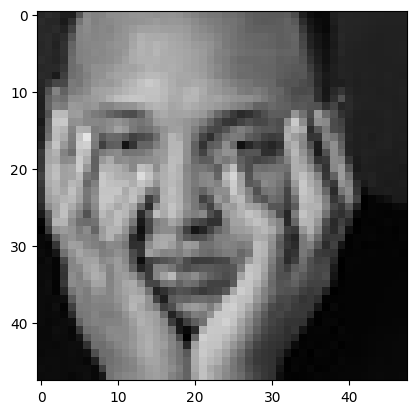

In [7]:
import torchvision.transforms as T
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random                   # For selecting a random element from the list

# Define transformations
transform = T.Compose([T.RandomHorizontalFlip(), T.ToTensor()])

# Training data
train_data = dset.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/images/train", transform=transform)
loaded_train = DataLoader(train_data, batch_size=64, shuffle=True)

# Validation data
validation_data = dset.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/images/validation", transform=transform)
loaded_validation = DataLoader(validation_data, batch_size=64, shuffle=False)

# Lists for tracking loss and accuracy
loss_history = []
validation_acc = []
training_acc = []

# Visualization setup
%matplotlib inline              

# Load a batch of training data
dataiter = iter(loaded_train)  # Using loaded_train instead of loader_train
images, labels = next(dataiter)  # Use next() to get the batch
expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}  # Mapping for labels

# Display a random image and its label
random_idx = random.sample(range(0, 64), 1)[0]  # Select a random index from 0 to 63
print("Target label:", expression[int(labels[random_idx].numpy())])  # Convert label tensor to numpy and map to expression
plt.imshow(np.transpose(images[random_idx].numpy(), (1, 2, 0)))  # Display image
plt.show()

In [8]:
def check_accuracy_part(loader, model):
    print('Checking accuracy on validation set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [9]:
def train_part(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print("epoch: ",e+1)
        for t, (x, y) in enumerate(loaded_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part(loaded_validation, model)
                print()

In [10]:
model = None
optimizer = None

#First architecture #3,32,32
conv1 = nn.Sequential(
    nn.Conv2d(3,512,kernel_size=(3,3),bias=True,padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))
)
conv2 = nn.Sequential(
    nn.Conv2d(512,128,kernel_size=(3,3),padding=1,bias=True),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))
)
conv3 = nn.Sequential(
    nn.Conv2d(128,64,kernel_size=(3,3),bias=True,padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))   #64,6,6
)
conv4 = nn.Sequential(
    nn.Conv2d(64,256,kernel_size=(3,3),bias=True,padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))   #256,3,3
)
fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*3*3,7),
)
model = nn.Sequential(
    conv1,
    conv2,
    conv3,
    conv4,
    fc
)
learning_rate=0.001
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
train_part(model, optimizer, epochs=10)

epoch:  1
Iteration 0, loss = 2.2861
Checking accuracy on validation set
Got 982 / 7066 correct (13.90)

Iteration 100, loss = 1.6592
Checking accuracy on validation set
Got 2393 / 7066 correct (33.87)

Iteration 200, loss = 1.7675
Checking accuracy on validation set
Got 2669 / 7066 correct (37.77)

Iteration 300, loss = 1.3439
Checking accuracy on validation set
Got 2883 / 7066 correct (40.80)

Iteration 400, loss = 1.4087
Checking accuracy on validation set
Got 3210 / 7066 correct (45.43)

epoch:  2
Iteration 0, loss = 1.1928
Checking accuracy on validation set
Got 2751 / 7066 correct (38.93)

Iteration 100, loss = 1.1913
Checking accuracy on validation set
Got 3648 / 7066 correct (51.63)

Iteration 200, loss = 1.0971
Checking accuracy on validation set
Got 3436 / 7066 correct (48.63)

Iteration 300, loss = 1.0582
Checking accuracy on validation set
Got 3625 / 7066 correct (51.30)

Iteration 400, loss = 1.1881
Checking accuracy on validation set
Got 3675 / 7066 correct (52.01)

epoch

In [11]:
#Best model
best_model = model
check_accuracy_part(loaded_validation,best_model)

Checking accuracy on validation set
Got 4047 / 7066 correct (57.27)


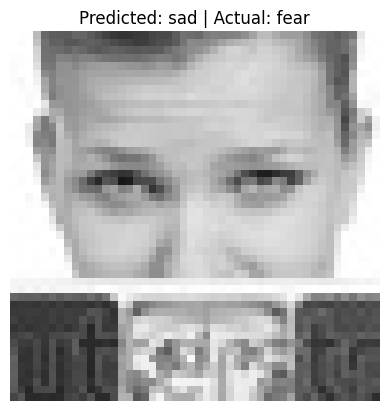

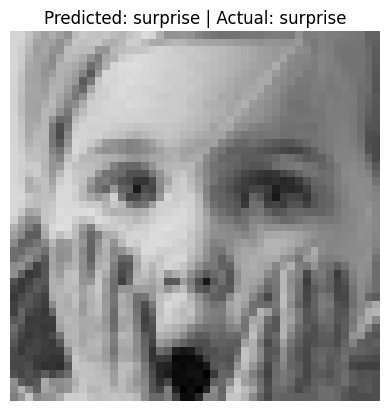

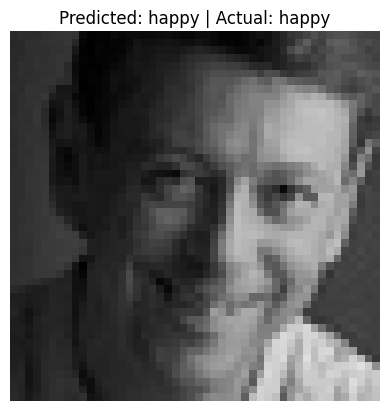

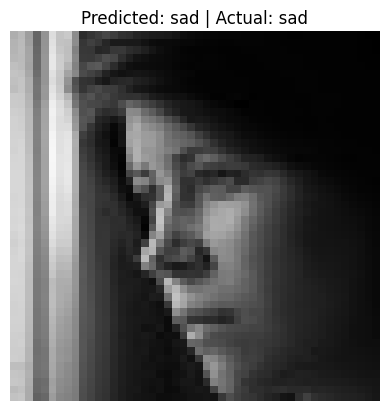

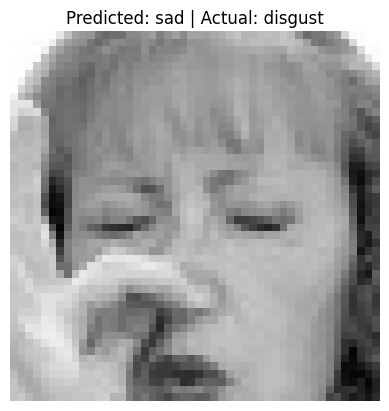

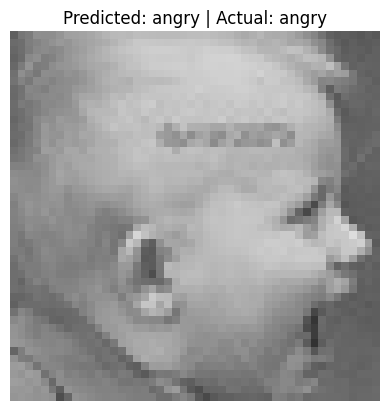

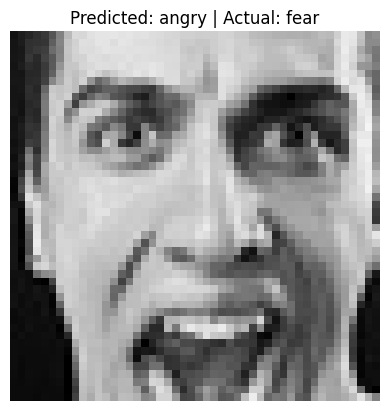

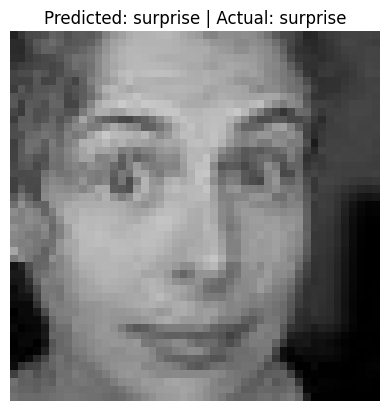

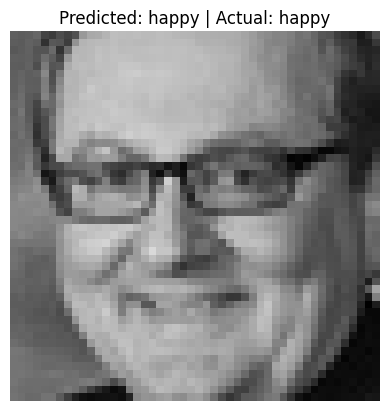

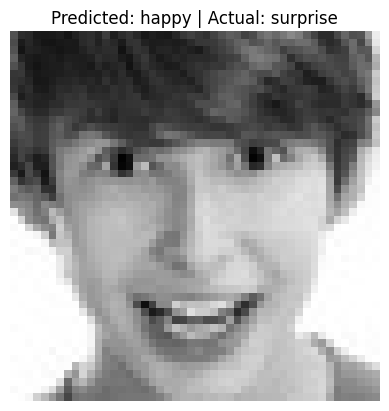

In [12]:
import torch
import torchvision.transforms as T
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# Define label mappings for the model's output
expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Define transformations for input images
transform = T.Compose([T.ToTensor()])

# Load validation data
validation_data = dset.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/images/validation", transform=transform)
loaded_validation = DataLoader(validation_data, batch_size=100, shuffle=True)

# Function to check accuracy and predict
def predict_image(image, model):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradient calculations
        image = image.to(device=device)  # Move image to device
        scores = model(image)  # Get model predictions
        _, predicted_label = scores.max(1)  # Get the highest score index
    return predicted_label

# Load a batch of validation data
dataiter = iter(loaded_validation)
images, labels = next(dataiter)

for i in range(10):
    # Pick a random image index to test and display
    random_idx = random.choice(range(len(images)))  # Random index within the batch size

    # Reshape and prepare image for prediction
    image = images[random_idx].unsqueeze(0)  # Add batch dimension
    predicted_label = predict_image(image, best_model)  # Get the model's prediction

#     # Print predicted and actual labels
#     print("Predicted label:", expression[predicted_label.item()])
#     print("Correct label:", expression[labels[random_idx].item()])

    # Display the image with its predicted label
    plt.imshow(np.transpose(images[random_idx].numpy(), (1, 2, 0)))
    plt.title(f"Predicted: {expression[predicted_label.item()]} | Actual: {expression[labels[random_idx].item()]}")
    plt.axis("off")
    plt.show()